# Segmenting price data using PELT model and change point detection

In [45]:
import numpy as np
import pandas as pd
import ruptures as rpt
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plot_constants as pltconst

pltconst.set_plot_parameters()

In [46]:
df = pd.read_csv("../../Data/Tezos/DataDuringProcessing/CleanDataShortTimePeriod/MarketAndPriceWithTI.csv")
df.head()

,date,market_cap,total_volume,close,high,low,open,high_low,high_low_pct,daily_change,...,EMA_7,EMA_30,MACD,MACD_signal,MACD_hist,RSI_7,RSI_14,STD_3,STD_7,STD_30
0,2018-08-02,1.147887e+09,2.989715e+06,1.766,2.000,1.694,1.903,0.306,1.180638,-0.137,...,1.976534,2.116131,-0.139597,-0.063401,-0.076196,13.129103,20.611552,0.091282,0.152743,0.189720
1,2018-08-03,1.046094e+09,3.179159e+06,1.861,1.964,1.633,1.766,0.331,1.202694,0.095,...,1.947647,2.097461,-0.149814,-0.080683,-0.069130,23.800384,34.113300,0.070188,0.154351,0.196030
2,2018-08-04,1.121301e+09,4.165820e+06,1.898,1.963,1.785,1.861,0.178,1.099720,0.037,...,1.935235,2.082991,-0.147756,-0.094098,-0.053658,27.022059,31.410256,0.068091,0.137980,0.197658
3,2018-08-05,1.148282e+09,2.817584e+06,1.856,1.957,1.823,1.898,0.134,1.073505,-0.042,...,1.915425,2.066654,-0.151229,-0.105524,-0.045705,26.063830,24.967490,0.022942,0.115789,0.201147
4,2018-08-06,1.126939e+09,2.108392e+06,1.846,1.969,1.810,1.856,0.159,1.087845,-0.010,...,1.898068,2.050891,-0.152823,-0.114984,-0.037839,23.613596,26.193724,0.027592,0.055136,0.206396


## 1. Fit the model and plot the detected change points

Function plotting the change points detected by the PELT model

In [60]:
def get_changepoint_plot(subplot, changepoints, dates, price_data, title = ""):
    if len(dates) in changepoints:
        changepoints.remove(len(dates))

    legend_elements = [
        Line2D([0], [0], color=pltconst.uzh_colors['blue'], label='Price Data', lw=2),
        Line2D([0], [0], color=pltconst.uzh_colors['red'], linestyle='--', label='Changepoint', lw=2)
    ]

    subplot.plot(df.date, price_data, color=pltconst.uzh_colors['blue'], label='Price Data')
    
    changepoint_dates = np.array(dates)[np.array(changepoints)]

    for cp in changepoint_dates:
        subplot.axvline(x=cp, color=pltconst.uzh_colors['red'], linestyle='--')

    subplot.legend(handles=legend_elements, loc='upper right')
    subplot.set_title(title)
    subplot.set_xlabel('Date', fontsize=20)
    subplot.set_ylabel('Price', fontsize=20)



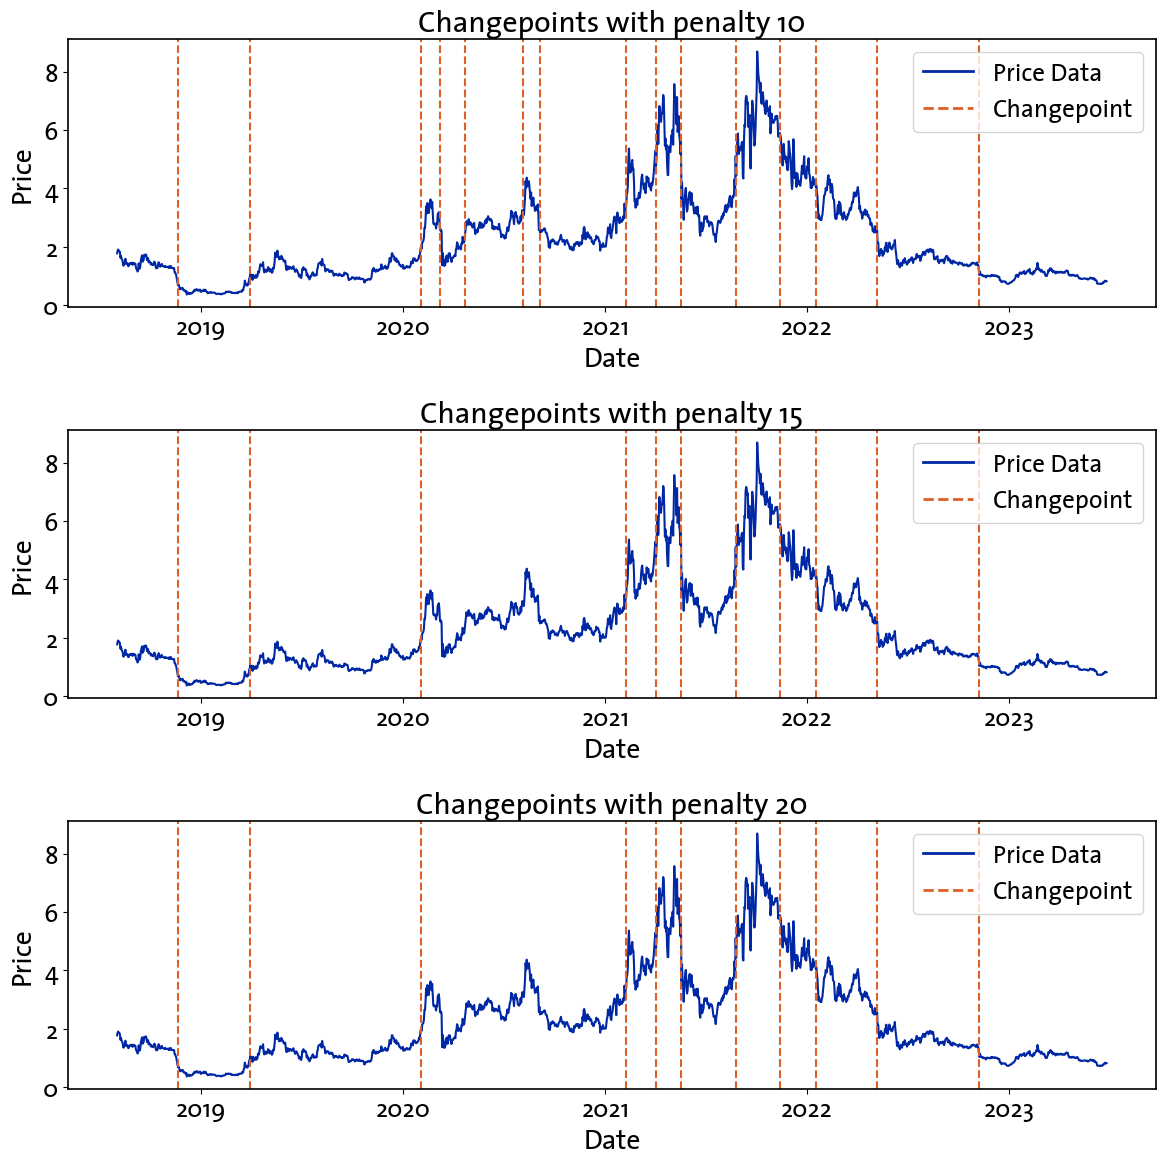

In [48]:
# Fit the model
df.date = pd.to_datetime(df.date)
dates = df.date.tolist()
price_data = df.close.values.reshape(-1, 1)

algo = rpt.Pelt(model="rbf").fit(price_data)

# Get the changepoints with different penalty parameters
changepoints_10 = algo.predict(pen=10)  
changepoints_15 = algo.predict(pen=15)  
changepoints_20 = algo.predict(pen=20) 

# Plot the different results for different penalty parameters
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
get_changepoint_plot(plt.gca(), changepoints_10, dates=dates, price_data=price_data, title="Changepoints with penalty 10")

plt.subplot(3, 1, 2)
get_changepoint_plot(plt.gca(), changepoints_15, dates=dates, price_data=price_data, title="Changepoints with penalty 15")

plt.subplot(3, 1, 3)
get_changepoint_plot(plt.gca(), changepoints_20, dates=dates, price_data=price_data, title="Changepoints with penalty 20")

plt.tight_layout()  
plt.show()



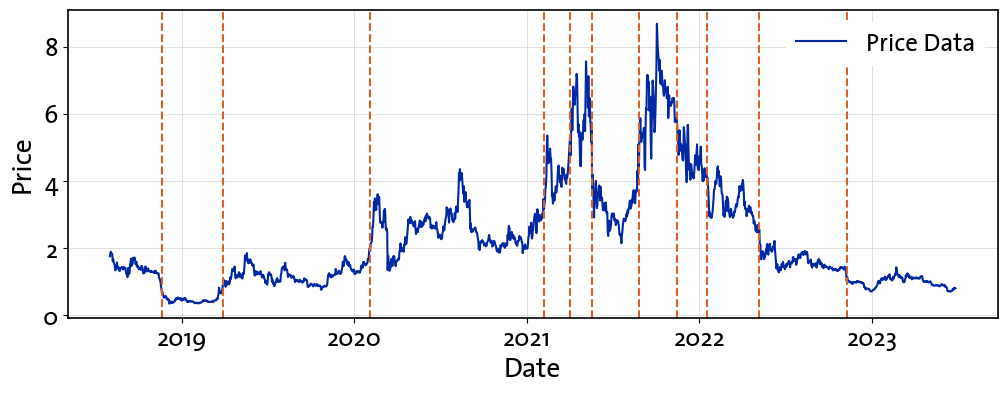

In [49]:
plt.figure(figsize=(12, 4))
title = "Change points for Tezos Price Data"
file_name = "../../Results/CV/Tezos_CPD.png"

get_changepoint_plot(plt.gca(), changepoints_20, dates=dates, price_data=price_data, title="")
leg = plt.legend(frameon=True,facecolor='white', framealpha=1)
frame = leg.get_frame()
frame.set_linewidth(0)
plt.grid(zorder=100, lw =0.5, color = 'lightgray')
plt.savefig(file_name, bbox_inches = 'tight')

From the former plots, it can be seen that the penalty values 15 and 20 detect the same change points. Penalty value of 10 produces a segmentation into a larger number of smaller intervals. Since very small fragmentation would not be optimal, segmentation using the penalty of 15 is chosen. In the following section the details about the data per segment are calculated,

## 2. Calculate and store segment statistics

In [5]:
changepoints = changepoints_15

if len(dates) in changepoints:
    changepoints.remove(len(dates))

segment_statistics = []

# Loop through each segment between changepoints
for i in range(len(changepoints) + 1):
    start_index = 0 if i == 0 else changepoints[i-1]
    end_index = -1 if i == len(changepoints) else changepoints[i]

    segment = price_data[start_index:end_index]
    
    # Calculate statistics for the current segment (e.g., mean and standard deviation)
    mean = np.mean(segment)
    std_dev = np.std(segment)
    
    # Store the statistics in a dictionary or data structure
    segment_statistics.append({
        'Segment': i,
        'Start Index': start_index,
        'End Index': end_index,
        'Start Date': dates[start_index],
        'End Date': dates[end_index],
        'Mean': mean,
        'Std Dev': std_dev
    })

stats_df = pd.DataFrame.from_dict(segment_statistics)
stats_df


,Segment,Start Index,End Index,Start Date,End Date,Mean,Std Dev
0,0,0,110,2018-08-02,2018-11-20,1.404299,0.185998
1,1,110,240,2018-11-20,2019-03-30,0.470481,0.101787
2,2,240,550,2019-03-30,2020-02-03,1.210297,0.238951
3,3,550,920,2020-02-03,2021-02-07,2.548573,0.542821
4,4,920,975,2021-02-07,2021-04-03,4.176409,0.496686
5,5,975,1020,2021-04-03,2021-05-18,5.993111,0.764057
6,6,1020,1120,2021-05-18,2021-08-26,3.201830,0.555449
7,7,1120,1200,2021-08-26,2021-11-14,6.346750,0.837159
8,8,1200,1265,2021-11-14,2022-01-18,4.668646,0.490449
9,9,1265,1375,2022-01-18,2022-05-08,3.323555,0.461734


In [7]:
stats_df.to_csv("../../Data/Tezos/CorrelationAndSegmentation/Tezos_segmentation_details.csv", index = False)

# CASPER

In [54]:
df = pd.read_csv("../../Data/Casper/Processed/Market.csv")
df.head()

df.rename({"DateTime":"date", "current_price":"close"}, axis = 1, inplace=True)
df.date = pd.to_datetime(df.date)
dates = df.date.tolist()
price_data = df.close.values.reshape(-1, 1)

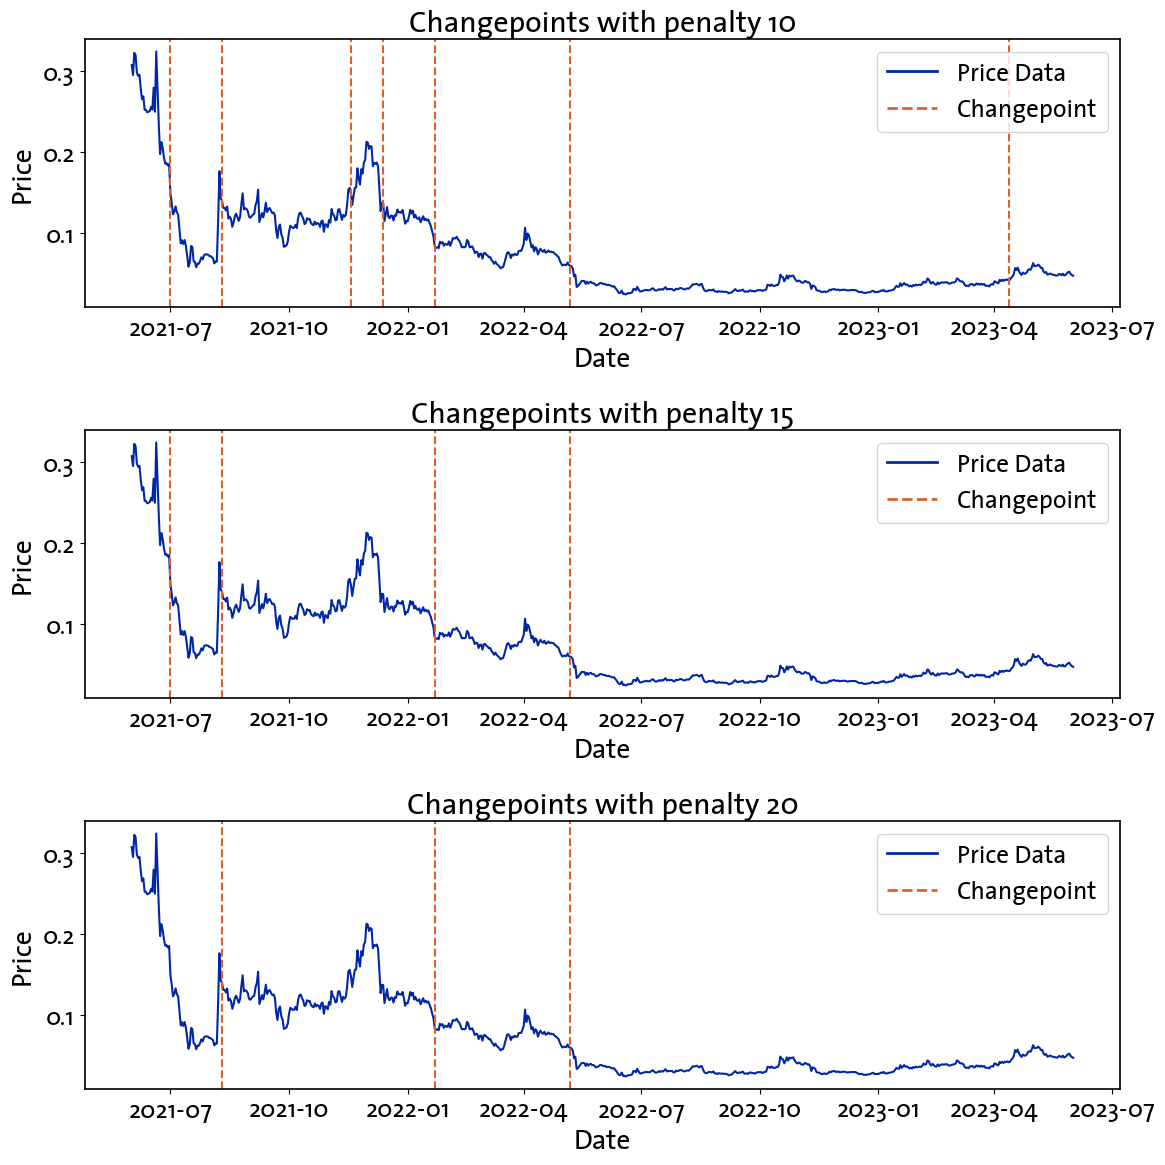

In [56]:
# Fit the model
algo = rpt.Pelt(model="rbf").fit(price_data)

# Get the changepoints with different penalty parameters
changepoints_10 = algo.predict(pen=10)  
changepoints_15 = algo.predict(pen=15)  
changepoints_20 = algo.predict(pen=20) 

# Plot the different results for different penalty parameters
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
get_changepoint_plot(plt.gca(), changepoints_10, dates=dates, price_data=price_data, title="Changepoints with penalty 10")

plt.subplot(3, 1, 2)
get_changepoint_plot(plt.gca(), changepoints_15, dates=dates, price_data=price_data, title="Changepoints with penalty 15")

plt.subplot(3, 1, 3)
get_changepoint_plot(plt.gca(), changepoints_20, dates=dates, price_data=price_data, title="Changepoints with penalty 20")

plt.tight_layout()  
plt.show()



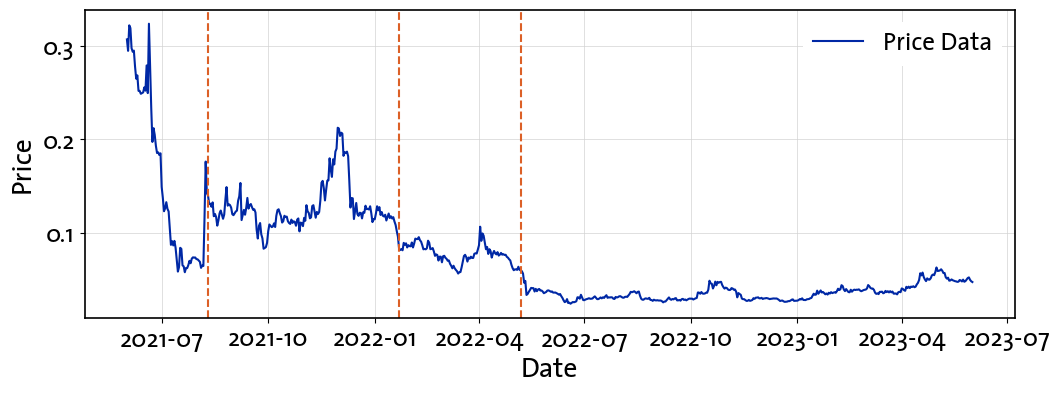

In [66]:
plt.figure(figsize=(12, 4))
title = "Change points for Casper Price Data"
file_name = "../../Results/CV/Casper_CPD.png"

get_changepoint_plot(plt.gca(), changepoints_20, dates=dates, price_data=price_data, title="")
leg = plt.legend(frameon=True,facecolor='white', framealpha=1)
frame = leg.get_frame()
frame.set_linewidth(0)
plt.grid(zorder=100, lw =0.5, color = 'lightgray')
plt.savefig(file_name, bbox_inches = 'tight')

In [43]:
changepoints = changepoints_15

if len(dates) in changepoints:
    changepoints.remove(len(dates))

segment_statistics = []

# Loop through each segment between changepoints
for i in range(len(changepoints) + 1):
    start_index = 0 if i == 0 else changepoints[i-1]
    end_index = -1 if i == len(changepoints) else changepoints[i]

    segment = price_data[start_index:end_index]
    
    # Calculate statistics for the current segment (e.g., mean and standard deviation)
    mean = np.mean(segment)
    std_dev = np.std(segment)
    
    # Store the statistics in a dictionary or data structure
    segment_statistics.append({
        'Segment': i,
        'Start Index': start_index,
        'End Index': end_index,
        'Start Date': dates[start_index],
        'End Date': dates[end_index],
        'Mean': mean,
        'Std Dev': std_dev
    })

stats_df = pd.DataFrame.from_dict(segment_statistics)

stats_df.to_csv("../../Data/Casper/CorrelationAndSegmentation/Casper_segmentation_details.csv", index = False)
stats_df


,Segment,Start Index,End Index,Start Date,End Date,Mean,Std Dev
0,0,0,30,2021-06-01,2021-07-01,0.253845,0.043275
1,1,30,70,2021-07-01,2021-08-10,0.088644,0.029789
2,2,70,235,2021-08-10,2022-01-22,0.127391,0.024668
3,3,235,340,2022-01-22,2022-05-07,0.077537,0.010275
4,4,340,-1,2022-05-07,2023-06-01,0.036271,0.008223
